In [1]:
import overpy
import time
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import ndimage
%matplotlib inline

In [2]:
API_WAIT_TIME = 60  # seconds
def run_overpy_query(search_term, country_code='DE'):
    
    api=overpy.Overpass()
    # see reg ex here: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#Value_matches_regular_expression_.28.7E.2C_.21.7E.29
    query_str = '''
    area["ISO3166-1"="{0}"][admin_level=2];
    (node["name"~"{1}", i](area);
    way["name"~"{1}", i](area);
    rel["name"~"{1}", i](area);
    );
    out center;
    '''.format(country_code, search_term)
    try:
        r = api.query(query_str)
    except:
        print('Query unsuccessful. Wait {} seconds and try again.'.format(API_WAIT_TIME))
        time.sleep(API_WAIT_TIME)
        r = api.query(query_str)
    
    # extract coordinates from query result
    coords  = []
    coords += [(float(node.lon), float(node.lat)) for node in r.nodes]
    coords += [(float(way.center_lon), float(way.center_lat)) for way in r.ways]
    coords += [(float(rel.center_lon), float(rel.center_lat)) for rel in r.relations]
    df = pd.DataFrame(coords)
    df.columns = ['lon', 'lat']
    
    return df

In [3]:
df_ka = run_overpy_query(search_term='adenauer')
df_ka.head()

Query unsuccessful. Wait 60 seconds and try again.


,lon,lat
0,9.988323,48.388831
1,8.692704,49.407714
2,6.273176,50.887146
3,13.307399,52.500242
4,8.929486,48.466880


In [4]:
def visualise_osm_scatter(search_term, title_name, country_code='DE', author_line=True):
    df = run_overpy_query(search_term=search_term, country_code=country_code)
    world = gpd.read_file('C:\\Users\\Richard\Desktop\\python\\heat_map\\ne_10m_admin_1_states_provinces\\ne_10m_admin_1_states_provinces.shp')
    fig, ax = plt.subplots(figsize=[8, 8])
    ax.axis('off')
    world[world['iso_a2']=='DE'].plot(color='w', edgecolor='black', linewidth=0.5, ax=ax)
    ax.scatter(df['lon'], df['lat'], c='red')
    ax.set_title('Location of the {} places\nnamed after {}\n'.format(len(df), title_name),
                 color=(0.41, 0.41, 0.41),
                 size=20)
    #author line
    if author_line:
        fig.text(0.99, 0.01, '@rikunert', color='lightgrey', style='italic',
             horizontalalignment='right')
    
    return fig, ax

Query unsuccessful. Wait 60 seconds and try again.


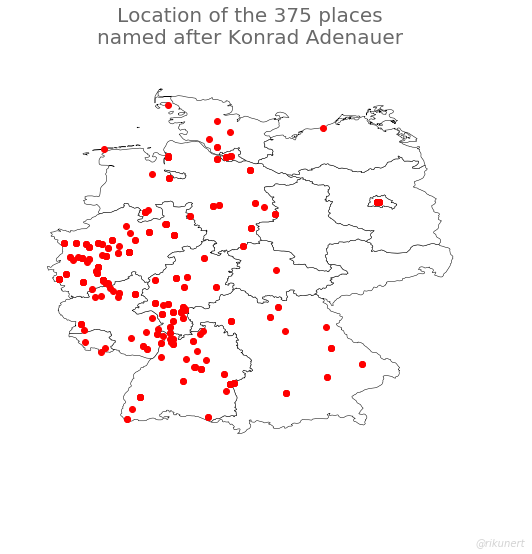

In [7]:
fig, ax = visualise_osm_scatter('adenauer', 'Konrad Adenauer')
fig.savefig('konrad_adenauer_scatter.png', bbox_inches='tight', dpi=1000)

In [10]:
def visualise_osm(search_term, title_name, country_code='DE', plot='heatmap', author_line=True):
    
    df = run_overpy_query(search_term=search_term, country_code=country_code)
    
    # plot query results on map of Germany
    world = gpd.read_file('C:\\Users\\Richard\Desktop\\python\\heat_map\\ne_10m_admin_1_states_provinces\\ne_10m_admin_1_states_provinces.shp')
    fig, ax = plt.subplots(figsize=[8, 8])
    ax.axis('off')
    if plot=='scatter':
        world[world['iso_a2']=='DE'].plot(color='w', edgecolor='black', linewidth=0.5, ax=ax)
        ax.scatter(df['lon'], df['lat'], c='red')
    elif plot=='heatmap':
        # see https://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434
        smoothing = 30  # smoothing factor
        bins=1000  # "pixel count"
        cmap='hot'  # color scale
        xlim = [5.7, 15.2]  # East-West extent of Germany
        ylim = [47.1, 55.1]  # North-South extent of Germany
        heatmap, xedges, yedges = np.histogram2d(df['lat'], df['lon'], 
                                                 bins=bins, range=[ylim, xlim])
        extent = [yedges[0], yedges[-1], 
                  xedges[-1], xedges[0]]
        logheatmap = np.log(heatmap)
        logheatmap[np.isneginf(logheatmap)] = 0
        logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')  # smooth out peaks
        logheatmap[logheatmap < 0.0001] = 0  # clearly show areas without occurence
        logheatmap = np.max(logheatmap) - logheatmap  # reverse color scale

        world[world['iso_a2']=='DE']['geometry'].boundary.plot(color='k', edgecolor='k', linewidth=0.2, ax=ax)
        ax.imshow(logheatmap, cmap=cmap, extent=extent)
        ax.invert_yaxis()
        ax.set(xlim=xlim, ylim=ylim)
        
    ax.set_title('Location of the {} places\nnamed after {}\n'.format(len(df), title_name),
                    color=(0.41, 0.41, 0.41),
                    size=20)
    #author line
    if author_line:
        fig.text(0.99, 0.01, '@rikunert', color='lightgrey', style='italic',
             horizontalalignment='right')
    
    return fig, ax

see https://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434

In [ ]:
fig, ax = visualise_osm('adenauer', 'Konrad Adenauer')
fig.savefig('konrad_adenauer.png', bbox_inches='tight', dpi=1000)

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


In [ ]:
fig, ax = visualise_osm('karl-liebknecht', 'Karl Liebknecht')
fig.savefig('karl_liebknecht.png', bbox_inches='tight', dpi=1000)

In [ ]:
fig, ax = visualise_osm('rosa-luxemburg', 'Rosa Luxemburg', plot='heatmap')
fig.savefig('rosa_luxemburg.png', bbox_inches='tight', dpi=1000)

In [ ]:
fig, ax = visualise_osm('hindenburg', 'Paul von Hindenburg', plot='heatmap')
fig.savefig('paul_von_hindenburg.png', bbox_inches='tight', dpi=1000)

In [ ]:
fig, ax = visualise_osm('luther', 'Martin Luther', plot='heatmap')
fig.savefig('martin_luther.png', bbox_inches='tight', dpi=1000)